# Neural Computing and Deep Learning (2019 MOD006568 TRI2 F01CAM)

### Element 010

### Student ID: 0925739

## Component 1: Turnitin code submission and Participation in Kaggle Challenge for  the Right Whale Recognition dataset

The mostly used libraries are first loaded in the cell below.

In [4]:
# Tensorflow, tf.keras, sys, os, OpenCV4 and PIL
import tensorflow as tf
from tensorflow import keras
import sys
import os
import cv2
from PIL import Image, ImageOps


# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
print(tf.__version__)

2.2.0


'train.csv' is a file given in the data source. This file contains the training dataset information. The file is loaded as a Pandas dataframe and first 5 lines are displayed.

In [8]:
data_label = pd.read_csv('train.csv')
data_label.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


As seen, the dataset consists of image file names and their corresponding whale IDs.

In [3]:
data_label.shape

(4544, 2)

Looking at the shape of the dataframe reveals the number of training examples we have available.

However, the learning models need to be trained on the actual images and not their filenames. The files are stored in './imgs' folder within the root directory. The below code will gather the filenames of all files within this directory.

In [3]:
all_files = os.listdir('./imgs')
print(len(all_files))

11469


This means that there are 11,469 images, out of which 4,544 are labelled with thier IDs and rest are not. It is at this point sensible to extract a separate list of files on which prediction is to be done.

In [4]:
prediction_files = [file for file in all_files if file not in data_label['Image'].tolist()]
print(len(prediction_files))

6925


To keep the dataframe neat and in the same order as files would appear in a folder, we can sort the dataframe by its 'Image' column.

In [9]:
data_label.sort_values('Image', inplace=True, ignore_index=True)
data_label.head()

,Image,whaleID
0,w_1.jpg,whale_72820
1,w_100.jpg,whale_66711
2,w_1000.jpg,whale_64496
3,w_1003.jpg,whale_48490
4,w_1004.jpg,whale_70138


At this point, it is sensible to look at some of the actual images. The below code allows us to see first 10.

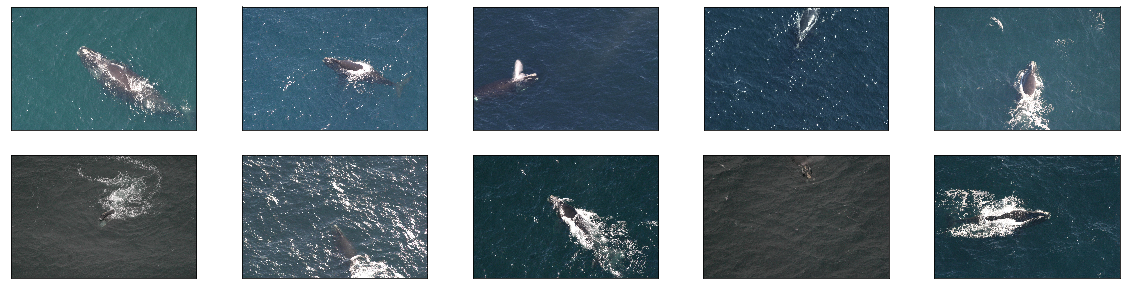

In [6]:
plt.figure(figsize=(20,5))
for i, image in enumerate(all_files[:10]):
    ax = plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = cv2.imread('imgs/{}'.format(image))
    
    # Convert BGR image to RGB:
    img_RGB = image[:, :, ::-1]

    # Show the image using matplotlib:
    plt.imshow(img_RGB)

It is noticed from the images that a huge portion of the image is just body of water or splashes caused by the whale. The training model may focus too much in the water body or splashes and hence the model may not generalise to make better predictions. Localising the whale's head to extract only the crop of the whale would allow the predictive model to focus only on the head.

To carry out localisation, annotations provided by Anil Thomas is utilised. His annotations mark two points in the training images; bonnetheads and blowholes. These are the two reference points within the whale's head which will allow cropping the whale's head.

Below code loads the annotations by Anil Thomas.

In [10]:
bonnetheads = pd.read_json('points1.json')
blowholes = pd.read_json('points2.json')

heads_annotations = bonnetheads['annotations'].tolist()
holes_annotations = blowholes['annotations'].tolist()
heads_annotations = [[element[0]['x'], element[0]['y']] for element in heads_annotations]
holes_annotations = [[element[0]['x'], element[0]['y']] for element in holes_annotations]

print('Bonnethead Annotations \n', heads_annotations[:5], '\n')
print('Blowholes Annotations \n', holes_annotations[:5])

Bonnethead Annotations 
 [[1361.8785425101214, 864.3886639676114], [1242.1615154536391, 573.431704885344], [1633.4995014955134, 908.6340977068793], [2431.8723828514453, 784.0797607178464], [3972.849451645065, 1567.77666999003]] 

Blowholes Annotations 
 [[1573.3117408906883, 903.7732793522267], [1289.8105682951145, 384.4785643070787], [1615.1226321036888, 1057.6909272183448], [2209.3080757726816, 939.2622133599201], [3583.489531405783, 1550.5483549351945]]


The loaded annotations are cleaned such that a list of coordinates x and y are kept in a list for easy access later. The coordinates are ordered in the same order as the training set filenames. Now a learning model could be trained to predict the x and y co-ordinates. This model will be used to predict the bonnethead and blowhole coordinates for prediction images.

At this point, we could check the total unique values in 'whaleID' column within the dataframe.

In [8]:
unique = data_label['whaleID'].value_counts()
print(unique.shape)

(447,)


This means there are a total of 447 whale IDs for which the training is to be done for recognition. The following code extracts the number of files available for each whale ID in training set.

In [9]:
grouped = data_label.groupby('whaleID').count().reset_index()
grouped.sort_values('Image', inplace=True, ignore_index=True)
grouped.head(20)

,whaleID,Image
0,whale_89271,1
1,whale_45294,1
2,whale_40483,1
3,whale_08729,1
4,whale_64299,1
5,whale_21655,1
6,whale_88085,1
7,whale_54497,1
8,whale_56281,1
9,whale_34513,1


In [11]:
grouped.tail(20)

,whaleID,Image
427,whale_26288,22
428,whale_87291,22
429,whale_73666,23
430,whale_95091,23
431,whale_68116,23
432,whale_79823,23
433,whale_89615,24
434,whale_08017,24
435,whale_34656,24
436,whale_78280,24


It is revealed that some of the whale IDs have just 1 image while there are some with as much as 40+ images. This could cause the learning model to have bias towards some whales. Data augmentation could be experimented to manouvre around this issue.

The function below loads the image data resized 192 x 128 as numpy arrays and creates targets of coordinates for both blowholes and bonnetheads in the resized image. The output of this fucnction will allow us to train a convolutional neural network for predicting nonnetheads and blowholes coordinates in prediction set. This prediction will allow for localisation which is when the whale heads can be cropped to be passed into recognition model.

In [10]:
def load_training_images_to_data(bonnetheads, blowholes, image_directory):
    
    # creating empty arrays in required shape
    features_data = np.zeros(128*192*3).reshape(1,128,192,3)
    target_heads = np.zeros(2)
    target_holes = np.zeros(2)
    
    list_of_files = data_label['Image'].tolist()   # filenames of training set
    
    for idx, file in enumerate(list_of_files):
        full_path = image_directory
        image_file_name = os.path.join(full_path, file)
        
        if ".jpg" in image_file_name:
            img = cv2.imread(image_file_name)
            
            # image resized for computational efficiency
            resized = cv2.resize(img, (192,128), interpolation=cv2.INTER_AREA)
            print("---------")
            print(resized.shape)
            print(idx, '/%s'%len(filenames))
            print("---------")       
            
            # reshaping and appending to features data
            resized = resized.reshape(1, 128, 192, 3)
            features_data = np.append(features_data, resized, axis = 0)
            
            # Creating blank bonnethead and blowhole array in the shape of original image size
            head = np.zeros(shape=img.shape[:2])
            hole = np.zeros(shape=img.shape[:2])
            
            # Assigning 1 as a value to the coordinates given by annotations
            head[int(bonnetheads[idx][1]), int(bonnetheads[idx][0])] = 1
            hole[int(blowholes[idx][1]), int(blowholes[idx][0])] = 1
            
            # Now resizing it to the 192 x 128 size
            head = cv2.resize(head, (192,128), interpolation=cv2.INTER_AREA)
            hole = cv2.resize(hole, (192,128), interpolation=cv2.INTER_AREA)
            
            # Finding non-zero coordinates of resized image
            head_row, head_col = np.nonzero(head)
            hole_row, hole_col = np.nonzero(hole)
            head_point = [head_row[0], head_col[0]]
            hole_point = [hole_row[0], hole_col[0]]
            
            # Creating target co-cordinates for which model can train on
            target_heads = np.append(target_heads, head_point, axis = 0)
            target_holes = np.append(target_holes, hole_point, axis = 0)
            
    #cleanup - removing first entry added at the top of the function        
    features_data = np.delete(features_data, 0, axis=0)        
    target_heads = np.delete(target_heads, 0, axis=0)
    target_holes = np.delete(target_holes, 0, axis=0)
    
    return features_data, target_heads, target_holes

Function is called below which processes all images in the training set. It is commented out and all three outputs are loaded from previously saved numpy files.

In [ ]:
#features_data, target_heads, target_holes = load_training_images_to_data(heads_annotations, holes_annotations, 'imgs/')

In [11]:
# np.save("features_data", features_data)
features_data = np.load('features_data.npy')
target_heads = np.load('target_heads.npy')
target_holes = np.load('target_holes.npy')

Now, it is time to start training the model. To do that a train_test_split can be called on the prepared data arrays and targets.

In [11]:
from sklearn.model_selection import train_test_split

In [958]:
x_train, x_test, y_train, y_test = train_test_split(features_data, target_heads, test_size=0.3, random_state=1)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)



(3180, 128, 192, 3) (1364, 128, 192, 3)
(3180, 2) (1364, 2)


In [355]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=10,
                        height_shift_range=0.1, zoom_range=0.2)
datagen.fit(x_train)
datagen2 = tf.keras.preprocessing.image.ImageDataGenerator()
datagen2.fit(x_test)

In [4]:
np.random.seed(6)
tf.random.set_seed(6)

head_model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (128, 192, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),

    keras.layers.Flatten(),
    keras.layers.Dense(500, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
])

In [5]:
head_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 192, 12)      336       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 64, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 64, 12)        1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 21, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 21, 12)        1308      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 7, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 336)               0

In [610]:
head_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['accuracy'])

In [514]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [612]:
head_history = head_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=20)

# history = model.fit(datagen.flow(x_train, y_train, batch_size=128,shuffle=True), validation_data= datagen2.flow(x_test, y_test, shuffle=True), epochs=20,verbose=1)

Train on 3635 samples, validate on 909 samples
Epoch 1/20
3635/3635 [==============================] - 13s 3ms/sample - loss: 309.0519 - accuracy: 0.8856 - val_loss: 366.9275 - val_accuracy: 0.8581
Epoch 2/20
3635/3635 [==============================] - 13s 3ms/sample - loss: 294.7738 - accuracy: 0.8894 - val_loss: 336.5370 - val_accuracy: 0.8614
Epoch 3/20
3635/3635 [==============================] - 14s 4ms/sample - loss: 268.9492 - accuracy: 0.8985 - val_loss: 322.4243 - val_accuracy: 0.8735
Epoch 4/20
3635/3635 [==============================] - 13s 3ms/sample - loss: 243.9326 - accuracy: 0.9032 - val_loss: 340.1974 - val_accuracy: 0.8757
Epoch 5/20
3635/3635 [==============================] - 13s 4ms/sample - loss: 231.7120 - accuracy: 0.9048 - val_loss: 303.8884 - val_accuracy: 0.8834
Epoch 6/20
3635/3635 [==============================] - 13s 3ms/sample - loss: 215.4069 - accuracy: 0.9103 - val_loss: 304.2754 - val_accuracy: 0.8878
Epoch 7/20
3635/3635 [=========================

In [629]:
x_train, x_test, y_train, y_test = train_test_split(features_data, target_holes, test_size=0.3, random_state=1)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


(3180, 128, 192, 3) (1364, 128, 192, 3)
(3180, 2) (1364, 2)


In [630]:
np.random.seed(12)
tf.random.set_seed(12)

hole_model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (128, 192, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),

    keras.layers.Flatten(),
    keras.layers.Dense(500, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
])

In [631]:

hole_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [632]:
hole_history = hole_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=20)

Train on 3180 samples, validate on 1364 samples
Epoch 1/20
3180/3180 [==============================] - 11s 4ms/sample - loss: 108.7588 - accuracy: 0.8918 - val_loss: 103.9618 - val_accuracy: 0.9348
Epoch 2/20
3180/3180 [==============================] - 11s 3ms/sample - loss: 103.6585 - accuracy: 0.9314 - val_loss: 103.6785 - val_accuracy: 0.9348
Epoch 3/20
3180/3180 [==============================] - 11s 4ms/sample - loss: 103.4638 - accuracy: 0.9311 - val_loss: 103.5713 - val_accuracy: 0.9348
Epoch 4/20
3180/3180 [==============================] - 11s 4ms/sample - loss: 103.3828 - accuracy: 0.9314 - val_loss: 103.4654 - val_accuracy: 0.9348
Epoch 5/20
3180/3180 [==============================] - 12s 4ms/sample - loss: 103.2852 - accuracy: 0.9318 - val_loss: 103.4330 - val_accuracy: 0.9348
Epoch 6/20
3180/3180 [==============================] - 11s 4ms/sample - loss: 103.2287 - accuracy: 0.9318 - val_loss: 103.3293 - val_accuracy: 0.9362
Epoch 7/20
3180/3180 [========================

The below code will take as input the image directory and load the prediction images only as numpy arrays features data which can be accepted by the models trained for localisation.

In [ ]:
def load_prediction_images_to_data(image_directory):
    features_data = np.zeros(128*192*3).reshape(1,128,192,3)
    list_of_files = [file for file in os.listdir(image_directory) if file not in filenames]
    for idx, file in enumerate(list_of_files):
        full_path = image_directory
        image_file_name = os.path.join(full_path, file)
        if ".jpg" in image_file_name:
            img = cv2.imread(image_file_name)
               #.convert("L")
            resized = cv2.resize(img, (192,128), interpolation=cv2.INTER_AREA)
            print("---------")
            print(resized.shape)
            print(idx, '/%s'%(len(list_of_files)-1))
            print("---------")       
            resized = resized.reshape(1, 128, 192, 3)
            features_data = np.append(features_data, resized, axis = 0)

    #cleanup - removing first entry added at the top of the function        
    features_data = np.delete(features_data, 0, axis=0)        
    return features_data

The below code loads all prediction images to data. It has been commented out and a previously saves numpy array has been loaded instead.

In [638]:
# pred_features_data = load_prediction_images_to_data('./imgs')
pred_features_data = np.load('pred_features_data.npy')

The trained models are then used to make co-ordinate predictions for both heads and holes for prediction images.

In [639]:
head_predictions = head_model.predict(pred_features_data)
hole_predictions = hole_model.predict(pred_features_data)

In [663]:
tf.keras.models.save_model(head_model, './')
tf.keras.models.save_model(hole_model, './')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./assets
INFO:tensorflow:Assets written to: ./assets


The below function takes as inputs the predicted bonnetheads and blowholes co-ordinates and the image directory as inputs and extracts the crops based on those co-ordinates for only the prediction images.

In [20]:
def extract_prediction_head_crops(bonnetheads, blowholes, image_directory, filenames):
    # Creating a numpy array of zeros in the required shape for neural network
    features_data = np.zeros(128*256*3).reshape(1,128,256,3)
    
    list_of_files = filenames
    
    # Looping over each file for which the whale ID is to be predicted
    for idx, file in enumerate(list_of_files):
        full_path = image_directory
        image_file_name = os.path.join(full_path, file)
        if ".jpg" in image_file_name:

            img_OpenCV = cv2.imread(image_file_name)
            print("---------")
            print(idx, '/%s'%len(list_of_files))
            print("---------")      
            
            # Assigning blowholes and bonnethead coordinates from predictions
            x1 = int(bonnetheads[idx][0])
            x2 = int(blowholes[idx][0])
            y1 = int(bonnetheads[idx][1])
            y2 = int(blowholes[idx][1])
            
            # Keeping co-ordinates within bounds
            if x1>127:
                x1=127
            if x2>127:
                x2=127
            if y1>191:
                y1=191
            if y2>191:
                y2=191
            
            # Creating an empty image of size 192 x 128 for storing the mask from co-ordinates
            empty_small1 = np.zeros(shape=(128,192))
            empty_small2 = np.zeros(shape=(128,192))
            empty_small1[x1, y1] = 1
            empty_small2[x2, y2] = 1

            # Resizing the empty image with mask to same size as original image
            empty_big1 = cv2.resize(empty_small1, (img_OpenCV.shape[1], img_OpenCV.shape[0]), interpolation=cv2.INTER_AREA)
            empty_big2 = cv2.resize(empty_small2, (img_OpenCV.shape[1], img_OpenCV.shape[0]), interpolation=cv2.INTER_AREA)

            # Finding non-zero coordinates in both dimensions
            y1, x1 = np.nonzero(empty_big1)
            y2, x2 = np.nonzero(empty_big2)
            
            # Taking the mean of found coordinates where the mask exists so that the midpoint is selected
            x1 = int(np.mean(x1))
            y1 = int(np.mean(y1))
            x2 = int(np.mean(x2))
            y2 = int(np.mean(y2))
            
            # Cropping, resizing, reshaping and appending to features_data
            ystart = min(y1,y2)-200
            yend = max(y1,y2)+200
            
            xstart = min(x1,x2)-200
            xend = max(x1,x2)+200
            
            # Keeping ystart and xstart within bounds for cropping
            if ystart<0:
                ystart=0
            if yend>img_OpenCV.shape[0]:
                yend = img_OpenCV.shape[0]-1
                
            if xstart<0:
                xstart=0
            if xend>img_OpenCV.shape[1]:
                xend = img_OpenCV.shape[1]-1
            
            # Cropping and appending to features_data
            cropped = img_OpenCV[ystart:yend, xstart:xend]
            if abs(x1-x2) < 200:
                cropped = cv2.rotate(cropped, cv2.ROTATE_90_CLOCKWISE)
            cropped = cv2.resize(cropped, (256,128), interpolation=cv2.INTER_AREA)
            cropped = cropped.reshape(1, 128, 256, 3)
            features_data = np.append(features_data, cropped, axis = 0)
            
    #cleanup - removing first entry added at the top of the function        
    features_data = np.delete(features_data, 0, axis=0)
    return features_data

In [808]:
prediction_cropped = extract_prediction_head_crops(head_predictions, hole_predictions, './imgs', prediction_files)

---------
0 /6925
---------
---------
1 /6925
---------
---------
2 /6925
---------
---------
3 /6925
---------
---------
4 /6925
---------
---------
5 /6925
---------
---------
6 /6925
---------
---------
7 /6925
---------
---------
8 /6925
---------
---------
9 /6925
---------
---------
10 /6925
---------
---------
11 /6925
---------
---------
12 /6925
---------
---------
13 /6925
---------
---------
14 /6925
---------
---------
15 /6925
---------
---------
16 /6925
---------
---------
17 /6925
---------
---------
18 /6925
---------
---------
19 /6925
---------
---------
20 /6925
---------
---------
21 /6925
---------
---------
22 /6925
---------
---------
23 /6925
---------
---------
24 /6925
---------
---------
25 /6925
---------
---------
26 /6925
---------
---------
27 /6925
---------
---------
28 /6925
---------
---------
29 /6925
---------
---------
30 /6925
---------
---------
31 /6925
---------
---------
32 /6925
---------
---------
33 /6925
---------
---------
34 /6925
-----

---------
277 /6925
---------
---------
278 /6925
---------
---------
279 /6925
---------
---------
280 /6925
---------
---------
281 /6925
---------
---------
282 /6925
---------
---------
283 /6925
---------
---------
284 /6925
---------
---------
285 /6925
---------
---------
286 /6925
---------
---------
287 /6925
---------
---------
288 /6925
---------
---------
289 /6925
---------
---------
290 /6925
---------
---------
291 /6925
---------
---------
292 /6925
---------
---------
293 /6925
---------
---------
294 /6925
---------
---------
295 /6925
---------
---------
296 /6925
---------
---------
297 /6925
---------
---------
298 /6925
---------
---------
299 /6925
---------
---------
300 /6925
---------
---------
301 /6925
---------
---------
302 /6925
---------
---------
303 /6925
---------
---------
304 /6925
---------
---------
305 /6925
---------
---------
306 /6925
---------
---------
307 /6925
---------
---------
308 /6925
---------
---------
309 /6925
---------
---------


---------
551 /6925
---------
---------
552 /6925
---------
---------
553 /6925
---------
---------
554 /6925
---------
---------
555 /6925
---------
---------
556 /6925
---------
---------
557 /6925
---------
---------
558 /6925
---------
---------
559 /6925
---------
---------
560 /6925
---------
---------
561 /6925
---------
---------
562 /6925
---------
---------
563 /6925
---------
---------
564 /6925
---------
---------
565 /6925
---------
---------
566 /6925
---------
---------
567 /6925
---------
---------
568 /6925
---------
---------
569 /6925
---------
---------
570 /6925
---------
---------
571 /6925
---------
---------
572 /6925
---------
---------
573 /6925
---------
---------
574 /6925
---------
---------
575 /6925
---------
---------
576 /6925
---------
---------
577 /6925
---------
---------
578 /6925
---------
---------
579 /6925
---------
---------
580 /6925
---------
---------
581 /6925
---------
---------
582 /6925
---------
---------
583 /6925
---------
---------


---------
825 /6925
---------
---------
826 /6925
---------
---------
827 /6925
---------
---------
828 /6925
---------
---------
829 /6925
---------
---------
830 /6925
---------
---------
831 /6925
---------
---------
832 /6925
---------
---------
833 /6925
---------
---------
834 /6925
---------
---------
835 /6925
---------
---------
836 /6925
---------
---------
837 /6925
---------
---------
838 /6925
---------
---------
839 /6925
---------
---------
840 /6925
---------
---------
841 /6925
---------
---------
842 /6925
---------
---------
843 /6925
---------
---------
844 /6925
---------
---------
845 /6925
---------
---------
846 /6925
---------
---------
847 /6925
---------
---------
848 /6925
---------
---------
849 /6925
---------
---------
850 /6925
---------
---------
851 /6925
---------
---------
852 /6925
---------
---------
853 /6925
---------
---------
854 /6925
---------
---------
855 /6925
---------
---------
856 /6925
---------
---------
857 /6925
---------
---------


---------
1095 /6925
---------
---------
1096 /6925
---------
---------
1097 /6925
---------
---------
1098 /6925
---------
---------
1099 /6925
---------
---------
1100 /6925
---------
---------
1101 /6925
---------
---------
1102 /6925
---------
---------
1103 /6925
---------
---------
1104 /6925
---------
---------
1105 /6925
---------
---------
1106 /6925
---------
---------
1107 /6925
---------
---------
1108 /6925
---------
---------
1109 /6925
---------
---------
1110 /6925
---------
---------
1111 /6925
---------
---------
1112 /6925
---------
---------
1113 /6925
---------
---------
1114 /6925
---------
---------
1115 /6925
---------
---------
1116 /6925
---------
---------
1117 /6925
---------
---------
1118 /6925
---------
---------
1119 /6925
---------
---------
1120 /6925
---------
---------
1121 /6925
---------
---------
1122 /6925
---------
---------
1123 /6925
---------
---------
1124 /6925
---------
---------
1125 /6925
---------
---------
1126 /6925
---------
--------

---------
1360 /6925
---------
---------
1361 /6925
---------
---------
1362 /6925
---------
---------
1363 /6925
---------
---------
1364 /6925
---------
---------
1365 /6925
---------
---------
1366 /6925
---------
---------
1367 /6925
---------
---------
1368 /6925
---------
---------
1369 /6925
---------
---------
1370 /6925
---------
---------
1371 /6925
---------
---------
1372 /6925
---------
---------
1373 /6925
---------
---------
1374 /6925
---------
---------
1375 /6925
---------
---------
1376 /6925
---------
---------
1377 /6925
---------
---------
1378 /6925
---------
---------
1379 /6925
---------
---------
1380 /6925
---------
---------
1381 /6925
---------
---------
1382 /6925
---------
---------
1383 /6925
---------
---------
1384 /6925
---------
---------
1385 /6925
---------
---------
1386 /6925
---------
---------
1387 /6925
---------
---------
1388 /6925
---------
---------
1389 /6925
---------
---------
1390 /6925
---------
---------
1391 /6925
---------
--------

---------
1625 /6925
---------
---------
1626 /6925
---------
---------
1627 /6925
---------
---------
1628 /6925
---------
---------
1629 /6925
---------
---------
1630 /6925
---------
---------
1631 /6925
---------
---------
1632 /6925
---------
---------
1633 /6925
---------
---------
1634 /6925
---------
---------
1635 /6925
---------
---------
1636 /6925
---------
---------
1637 /6925
---------
---------
1638 /6925
---------
---------
1639 /6925
---------
---------
1640 /6925
---------
---------
1641 /6925
---------
---------
1642 /6925
---------
---------
1643 /6925
---------
---------
1644 /6925
---------
---------
1645 /6925
---------
---------
1646 /6925
---------
---------
1647 /6925
---------
---------
1648 /6925
---------
---------
1649 /6925
---------
---------
1650 /6925
---------
---------
1651 /6925
---------
---------
1652 /6925
---------
---------
1653 /6925
---------
---------
1654 /6925
---------
---------
1655 /6925
---------
---------
1656 /6925
---------
--------

---------
1890 /6925
---------
---------
1891 /6925
---------
---------
1892 /6925
---------
---------
1893 /6925
---------
---------
1894 /6925
---------
---------
1895 /6925
---------
---------
1896 /6925
---------
---------
1897 /6925
---------
---------
1898 /6925
---------
---------
1899 /6925
---------
---------
1900 /6925
---------
---------
1901 /6925
---------
---------
1902 /6925
---------
---------
1903 /6925
---------
---------
1904 /6925
---------
---------
1905 /6925
---------
---------
1906 /6925
---------
---------
1907 /6925
---------
---------
1908 /6925
---------
---------
1909 /6925
---------
---------
1910 /6925
---------
---------
1911 /6925
---------
---------
1912 /6925
---------
---------
1913 /6925
---------
---------
1914 /6925
---------
---------
1915 /6925
---------
---------
1916 /6925
---------
---------
1917 /6925
---------
---------
1918 /6925
---------
---------
1919 /6925
---------
---------
1920 /6925
---------
---------
1921 /6925
---------
--------

---------
2155 /6925
---------
---------
2156 /6925
---------
---------
2157 /6925
---------
---------
2158 /6925
---------
---------
2159 /6925
---------
---------
2160 /6925
---------
---------
2161 /6925
---------
---------
2162 /6925
---------
---------
2163 /6925
---------
---------
2164 /6925
---------
---------
2165 /6925
---------
---------
2166 /6925
---------
---------
2167 /6925
---------
---------
2168 /6925
---------
---------
2169 /6925
---------
---------
2170 /6925
---------
---------
2171 /6925
---------
---------
2172 /6925
---------
---------
2173 /6925
---------
---------
2174 /6925
---------
---------
2175 /6925
---------
---------
2176 /6925
---------
---------
2177 /6925
---------
---------
2178 /6925
---------
---------
2179 /6925
---------
---------
2180 /6925
---------
---------
2181 /6925
---------
---------
2182 /6925
---------
---------
2183 /6925
---------
---------
2184 /6925
---------
---------
2185 /6925
---------
---------
2186 /6925
---------
--------

---------
2420 /6925
---------
---------
2421 /6925
---------
---------
2422 /6925
---------
---------
2423 /6925
---------
---------
2424 /6925
---------
---------
2425 /6925
---------
---------
2426 /6925
---------
---------
2427 /6925
---------
---------
2428 /6925
---------
---------
2429 /6925
---------
---------
2430 /6925
---------
---------
2431 /6925
---------
---------
2432 /6925
---------
---------
2433 /6925
---------
---------
2434 /6925
---------
---------
2435 /6925
---------
---------
2436 /6925
---------
---------
2437 /6925
---------
---------
2438 /6925
---------
---------
2439 /6925
---------
---------
2440 /6925
---------
---------
2441 /6925
---------
---------
2442 /6925
---------
---------
2443 /6925
---------
---------
2444 /6925
---------
---------
2445 /6925
---------
---------
2446 /6925
---------
---------
2447 /6925
---------
---------
2448 /6925
---------
---------
2449 /6925
---------
---------
2450 /6925
---------
---------
2451 /6925
---------
--------

---------
2685 /6925
---------
---------
2686 /6925
---------
---------
2687 /6925
---------
---------
2688 /6925
---------
---------
2689 /6925
---------
---------
2690 /6925
---------
---------
2691 /6925
---------
---------
2692 /6925
---------
---------
2693 /6925
---------
---------
2694 /6925
---------
---------
2695 /6925
---------
---------
2696 /6925
---------
---------
2697 /6925
---------
---------
2698 /6925
---------
---------
2699 /6925
---------
---------
2700 /6925
---------
---------
2701 /6925
---------
---------
2702 /6925
---------
---------
2703 /6925
---------
---------
2704 /6925
---------
---------
2705 /6925
---------
---------
2706 /6925
---------
---------
2707 /6925
---------
---------
2708 /6925
---------
---------
2709 /6925
---------
---------
2710 /6925
---------
---------
2711 /6925
---------
---------
2712 /6925
---------
---------
2713 /6925
---------
---------
2714 /6925
---------
---------
2715 /6925
---------
---------
2716 /6925
---------
--------

---------
2950 /6925
---------
---------
2951 /6925
---------
---------
2952 /6925
---------
---------
2953 /6925
---------
---------
2954 /6925
---------
---------
2955 /6925
---------
---------
2956 /6925
---------
---------
2957 /6925
---------
---------
2958 /6925
---------
---------
2959 /6925
---------
---------
2960 /6925
---------
---------
2961 /6925
---------
---------
2962 /6925
---------
---------
2963 /6925
---------
---------
2964 /6925
---------
---------
2965 /6925
---------
---------
2966 /6925
---------
---------
2967 /6925
---------
---------
2968 /6925
---------
---------
2969 /6925
---------
---------
2970 /6925
---------
---------
2971 /6925
---------
---------
2972 /6925
---------
---------
2973 /6925
---------
---------
2974 /6925
---------
---------
2975 /6925
---------
---------
2976 /6925
---------
---------
2977 /6925
---------
---------
2978 /6925
---------
---------
2979 /6925
---------
---------
2980 /6925
---------
---------
2981 /6925
---------
--------

---------
3215 /6925
---------
---------
3216 /6925
---------
---------
3217 /6925
---------
---------
3218 /6925
---------
---------
3219 /6925
---------
---------
3220 /6925
---------
---------
3221 /6925
---------
---------
3222 /6925
---------
---------
3223 /6925
---------
---------
3224 /6925
---------
---------
3225 /6925
---------
---------
3226 /6925
---------
---------
3227 /6925
---------
---------
3228 /6925
---------
---------
3229 /6925
---------
---------
3230 /6925
---------
---------
3231 /6925
---------
---------
3232 /6925
---------
---------
3233 /6925
---------
---------
3234 /6925
---------
---------
3235 /6925
---------
---------
3236 /6925
---------
---------
3237 /6925
---------
---------
3238 /6925
---------
---------
3239 /6925
---------
---------
3240 /6925
---------
---------
3241 /6925
---------
---------
3242 /6925
---------
---------
3243 /6925
---------
---------
3244 /6925
---------
---------
3245 /6925
---------
---------
3246 /6925
---------
--------

---------
3480 /6925
---------
---------
3481 /6925
---------
---------
3482 /6925
---------
---------
3483 /6925
---------
---------
3484 /6925
---------
---------
3485 /6925
---------
---------
3486 /6925
---------
---------
3487 /6925
---------
---------
3488 /6925
---------
---------
3489 /6925
---------
---------
3490 /6925
---------
---------
3491 /6925
---------
---------
3492 /6925
---------
---------
3493 /6925
---------
---------
3494 /6925
---------
---------
3495 /6925
---------
---------
3496 /6925
---------
---------
3497 /6925
---------
---------
3498 /6925
---------
---------
3499 /6925
---------
---------
3500 /6925
---------
---------
3501 /6925
---------
---------
3502 /6925
---------
---------
3503 /6925
---------
---------
3504 /6925
---------
---------
3505 /6925
---------
---------
3506 /6925
---------
---------
3507 /6925
---------
---------
3508 /6925
---------
---------
3509 /6925
---------
---------
3510 /6925
---------
---------
3511 /6925
---------
--------

---------
3745 /6925
---------
---------
3746 /6925
---------
---------
3747 /6925
---------
---------
3748 /6925
---------
---------
3749 /6925
---------
---------
3750 /6925
---------
---------
3751 /6925
---------
---------
3752 /6925
---------
---------
3753 /6925
---------
---------
3754 /6925
---------
---------
3755 /6925
---------
---------
3756 /6925
---------
---------
3757 /6925
---------
---------
3758 /6925
---------
---------
3759 /6925
---------
---------
3760 /6925
---------
---------
3761 /6925
---------
---------
3762 /6925
---------
---------
3763 /6925
---------
---------
3764 /6925
---------
---------
3765 /6925
---------
---------
3766 /6925
---------
---------
3767 /6925
---------
---------
3768 /6925
---------
---------
3769 /6925
---------
---------
3770 /6925
---------
---------
3771 /6925
---------
---------
3772 /6925
---------
---------
3773 /6925
---------
---------
3774 /6925
---------
---------
3775 /6925
---------
---------
3776 /6925
---------
--------

---------
4010 /6925
---------
---------
4011 /6925
---------
---------
4012 /6925
---------
---------
4013 /6925
---------
---------
4014 /6925
---------
---------
4015 /6925
---------
---------
4016 /6925
---------
---------
4017 /6925
---------
---------
4018 /6925
---------
---------
4019 /6925
---------
---------
4020 /6925
---------
---------
4021 /6925
---------
---------
4022 /6925
---------
---------
4023 /6925
---------
---------
4024 /6925
---------
---------
4025 /6925
---------
---------
4026 /6925
---------
---------
4027 /6925
---------
---------
4028 /6925
---------
---------
4029 /6925
---------
---------
4030 /6925
---------
---------
4031 /6925
---------
---------
4032 /6925
---------
---------
4033 /6925
---------
---------
4034 /6925
---------
---------
4035 /6925
---------
---------
4036 /6925
---------
---------
4037 /6925
---------
---------
4038 /6925
---------
---------
4039 /6925
---------
---------
4040 /6925
---------
---------
4041 /6925
---------
--------

---------
4275 /6925
---------
---------
4276 /6925
---------
---------
4277 /6925
---------
---------
4278 /6925
---------
---------
4279 /6925
---------
---------
4280 /6925
---------
---------
4281 /6925
---------
---------
4282 /6925
---------
---------
4283 /6925
---------
---------
4284 /6925
---------
---------
4285 /6925
---------
---------
4286 /6925
---------
---------
4287 /6925
---------
---------
4288 /6925
---------
---------
4289 /6925
---------
---------
4290 /6925
---------
---------
4291 /6925
---------
---------
4292 /6925
---------
---------
4293 /6925
---------
---------
4294 /6925
---------
---------
4295 /6925
---------
---------
4296 /6925
---------
---------
4297 /6925
---------
---------
4298 /6925
---------
---------
4299 /6925
---------
---------
4300 /6925
---------
---------
4301 /6925
---------
---------
4302 /6925
---------
---------
4303 /6925
---------
---------
4304 /6925
---------
---------
4305 /6925
---------
---------
4306 /6925
---------
--------

---------
4540 /6925
---------
---------
4541 /6925
---------
---------
4542 /6925
---------
---------
4543 /6925
---------
---------
4544 /6925
---------
---------
4545 /6925
---------
---------
4546 /6925
---------
---------
4547 /6925
---------
---------
4548 /6925
---------
---------
4549 /6925
---------
---------
4550 /6925
---------
---------
4551 /6925
---------
---------
4552 /6925
---------
---------
4553 /6925
---------
---------
4554 /6925
---------
---------
4555 /6925
---------
---------
4556 /6925
---------
---------
4557 /6925
---------
---------
4558 /6925
---------
---------
4559 /6925
---------
---------
4560 /6925
---------
---------
4561 /6925
---------
---------
4562 /6925
---------
---------
4563 /6925
---------
---------
4564 /6925
---------
---------
4565 /6925
---------
---------
4566 /6925
---------
---------
4567 /6925
---------
---------
4568 /6925
---------
---------
4569 /6925
---------
---------
4570 /6925
---------
---------
4571 /6925
---------
--------

---------
4805 /6925
---------
---------
4806 /6925
---------
---------
4807 /6925
---------
---------
4808 /6925
---------
---------
4809 /6925
---------
---------
4810 /6925
---------
---------
4811 /6925
---------
---------
4812 /6925
---------
---------
4813 /6925
---------
---------
4814 /6925
---------
---------
4815 /6925
---------
---------
4816 /6925
---------
---------
4817 /6925
---------
---------
4818 /6925
---------
---------
4819 /6925
---------
---------
4820 /6925
---------
---------
4821 /6925
---------
---------
4822 /6925
---------
---------
4823 /6925
---------
---------
4824 /6925
---------
---------
4825 /6925
---------
---------
4826 /6925
---------
---------
4827 /6925
---------
---------
4828 /6925
---------
---------
4829 /6925
---------
---------
4830 /6925
---------
---------
4831 /6925
---------
---------
4832 /6925
---------
---------
4833 /6925
---------
---------
4834 /6925
---------
---------
4835 /6925
---------
---------
4836 /6925
---------
--------

---------
5070 /6925
---------
---------
5071 /6925
---------
---------
5072 /6925
---------
---------
5073 /6925
---------
---------
5074 /6925
---------
---------
5075 /6925
---------
---------
5076 /6925
---------
---------
5077 /6925
---------
---------
5078 /6925
---------
---------
5079 /6925
---------
---------
5080 /6925
---------
---------
5081 /6925
---------
---------
5082 /6925
---------
---------
5083 /6925
---------
---------
5084 /6925
---------
---------
5085 /6925
---------
---------
5086 /6925
---------
---------
5087 /6925
---------
---------
5088 /6925
---------
---------
5089 /6925
---------
---------
5090 /6925
---------
---------
5091 /6925
---------
---------
5092 /6925
---------
---------
5093 /6925
---------
---------
5094 /6925
---------
---------
5095 /6925
---------
---------
5096 /6925
---------
---------
5097 /6925
---------
---------
5098 /6925
---------
---------
5099 /6925
---------
---------
5100 /6925
---------
---------
5101 /6925
---------
--------

---------
5335 /6925
---------
---------
5336 /6925
---------
---------
5337 /6925
---------
---------
5338 /6925
---------
---------
5339 /6925
---------
---------
5340 /6925
---------
---------
5341 /6925
---------
---------
5342 /6925
---------
---------
5343 /6925
---------
---------
5344 /6925
---------
---------
5345 /6925
---------
---------
5346 /6925
---------
---------
5347 /6925
---------
---------
5348 /6925
---------
---------
5349 /6925
---------
---------
5350 /6925
---------
---------
5351 /6925
---------
---------
5352 /6925
---------
---------
5353 /6925
---------
---------
5354 /6925
---------
---------
5355 /6925
---------
---------
5356 /6925
---------
---------
5357 /6925
---------
---------
5358 /6925
---------
---------
5359 /6925
---------
---------
5360 /6925
---------
---------
5361 /6925
---------
---------
5362 /6925
---------
---------
5363 /6925
---------
---------
5364 /6925
---------
---------
5365 /6925
---------
---------
5366 /6925
---------
--------

---------
5600 /6925
---------
---------
5601 /6925
---------
---------
5602 /6925
---------
---------
5603 /6925
---------
---------
5604 /6925
---------
---------
5605 /6925
---------
---------
5606 /6925
---------
---------
5607 /6925
---------
---------
5608 /6925
---------
---------
5609 /6925
---------
---------
5610 /6925
---------
---------
5611 /6925
---------
---------
5612 /6925
---------
---------
5613 /6925
---------
---------
5614 /6925
---------
---------
5615 /6925
---------
---------
5616 /6925
---------
---------
5617 /6925
---------
---------
5618 /6925
---------
---------
5619 /6925
---------
---------
5620 /6925
---------
---------
5621 /6925
---------
---------
5622 /6925
---------
---------
5623 /6925
---------
---------
5624 /6925
---------
---------
5625 /6925
---------
---------
5626 /6925
---------
---------
5627 /6925
---------
---------
5628 /6925
---------
---------
5629 /6925
---------
---------
5630 /6925
---------
---------
5631 /6925
---------
--------

---------
5865 /6925
---------
---------
5866 /6925
---------
---------
5867 /6925
---------
---------
5868 /6925
---------
---------
5869 /6925
---------
---------
5870 /6925
---------
---------
5871 /6925
---------
---------
5872 /6925
---------
---------
5873 /6925
---------
---------
5874 /6925
---------
---------
5875 /6925
---------
---------
5876 /6925
---------
---------
5877 /6925
---------
---------
5878 /6925
---------
---------
5879 /6925
---------
---------
5880 /6925
---------
---------
5881 /6925
---------
---------
5882 /6925
---------
---------
5883 /6925
---------
---------
5884 /6925
---------
---------
5885 /6925
---------
---------
5886 /6925
---------
---------
5887 /6925
---------
---------
5888 /6925
---------
---------
5889 /6925
---------
---------
5890 /6925
---------
---------
5891 /6925
---------
---------
5892 /6925
---------
---------
5893 /6925
---------
---------
5894 /6925
---------
---------
5895 /6925
---------
---------
5896 /6925
---------
--------

---------
6130 /6925
---------
---------
6131 /6925
---------
---------
6132 /6925
---------
---------
6133 /6925
---------
---------
6134 /6925
---------
---------
6135 /6925
---------
---------
6136 /6925
---------
---------
6137 /6925
---------
---------
6138 /6925
---------
---------
6139 /6925
---------
---------
6140 /6925
---------
---------
6141 /6925
---------
---------
6142 /6925
---------
---------
6143 /6925
---------
---------
6144 /6925
---------
---------
6145 /6925
---------
---------
6146 /6925
---------
---------
6147 /6925
---------
---------
6148 /6925
---------
---------
6149 /6925
---------
---------
6150 /6925
---------
---------
6151 /6925
---------
---------
6152 /6925
---------
---------
6153 /6925
---------
---------
6154 /6925
---------
---------
6155 /6925
---------
---------
6156 /6925
---------
---------
6157 /6925
---------
---------
6158 /6925
---------
---------
6159 /6925
---------
---------
6160 /6925
---------
---------
6161 /6925
---------
--------

---------
6395 /6925
---------
---------
6396 /6925
---------
---------
6397 /6925
---------
---------
6398 /6925
---------
---------
6399 /6925
---------
---------
6400 /6925
---------
---------
6401 /6925
---------
---------
6402 /6925
---------
---------
6403 /6925
---------
---------
6404 /6925
---------
---------
6405 /6925
---------
---------
6406 /6925
---------
---------
6407 /6925
---------
---------
6408 /6925
---------
---------
6409 /6925
---------
---------
6410 /6925
---------
---------
6411 /6925
---------
---------
6412 /6925
---------
---------
6413 /6925
---------
---------
6414 /6925
---------
---------
6415 /6925
---------
---------
6416 /6925
---------
---------
6417 /6925
---------
---------
6418 /6925
---------
---------
6419 /6925
---------
---------
6420 /6925
---------
---------
6421 /6925
---------
---------
6422 /6925
---------
---------
6423 /6925
---------
---------
6424 /6925
---------
---------
6425 /6925
---------
---------
6426 /6925
---------
--------

---------
6660 /6925
---------
---------
6661 /6925
---------
---------
6662 /6925
---------
---------
6663 /6925
---------
---------
6664 /6925
---------
---------
6665 /6925
---------
---------
6666 /6925
---------
---------
6667 /6925
---------
---------
6668 /6925
---------
---------
6669 /6925
---------
---------
6670 /6925
---------
---------
6671 /6925
---------
---------
6672 /6925
---------
---------
6673 /6925
---------
---------
6674 /6925
---------
---------
6675 /6925
---------
---------
6676 /6925
---------
---------
6677 /6925
---------
---------
6678 /6925
---------
---------
6679 /6925
---------
---------
6680 /6925
---------
---------
6681 /6925
---------
---------
6682 /6925
---------
---------
6683 /6925
---------
---------
6684 /6925
---------
---------
6685 /6925
---------
---------
6686 /6925
---------
---------
6687 /6925
---------
---------
6688 /6925
---------
---------
6689 /6925
---------
---------
6690 /6925
---------
---------
6691 /6925
---------
--------

In [21]:
# np.save('prediction_cropped', prediction_cropped)
prediction_cropped = np.load('prediction_cropped.npy')

In [15]:
prediction_cropped.shape

(6925, 128, 256, 3)

Similarly, below function crops the training images based on original bonnethead and blowhole annotations.

In [22]:
def extract_training_head_crops(bonnetheads, blowholes, image_directory, filenames):
    # Creating a numpy array of zeros in the required shape for neural network
    features_data = np.zeros(128*256*3).reshape(1,128,256,3)
    
    list_of_files = filenames
    
    # Looping over each file for which the whale ID is to be predicted
    for idx, file in enumerate(list_of_files[:20]):
        full_path = image_directory
        image_file_name = os.path.join(full_path, file)
        if ".jpg" in image_file_name:

            img_OpenCV = cv2.imread(image_file_name)
            print("---------")
            print(idx+1, '/%s'%len(list_of_files))
            print("---------")      
            
            x1 = int(bonnetheads[idx][0])
            x2 = int(blowholes[idx][0])
            y1 = int(bonnetheads[idx][1])
            y2 = int(blowholes[idx][1])
            
            ystart = min(y1,y2)-200
            yend = max(y1,y2)+200
            
            xstart = min(x1,x2)-200
            xend = max(x1,x2)+200
            
            if ystart<0:
                ystart=0
            if yend>img_OpenCV.shape[0]:
                yend = img_OpenCV.shape[0]-1
                
            if xstart<0:
                xstart=0
            if xend>img_OpenCV.shape[1]:
                xend = img_OpenCV.shape[1]-1
            
            
            cropped = img_OpenCV[ystart:yend, xstart:xend]
            if abs(x1-x2) < 200:
                cropped = cv2.rotate(cropped, cv2.ROTATE_90_CLOCKWISE)
            cropped = cv2.resize(cropped, (256,128), interpolation=cv2.INTER_AREA)
            cropped = cropped.reshape(1, 128, 256, 3)
            features_data = np.append(features_data, cropped, axis = 0)
            
    #cleanup - removing first entry added at the top of the function        
    features_data = np.delete(features_data, 0, axis=0)
    return features_data

The function is called below to extract the crops for training images.

In [873]:
training_cropped = extract_training_head_crops(heads_annotations, holes_annotations, './imgs', data_label['Image'].tolist())

---------
0 /4544
---------
---------
1 /4544
---------
---------
2 /4544
---------
---------
3 /4544
---------
---------
4 /4544
---------
---------
5 /4544
---------
---------
6 /4544
---------
---------
7 /4544
---------
---------
8 /4544
---------
---------
9 /4544
---------
---------
10 /4544
---------
---------
11 /4544
---------
---------
12 /4544
---------
---------
13 /4544
---------
---------
14 /4544
---------
---------
15 /4544
---------
---------
16 /4544
---------
---------
17 /4544
---------
---------
18 /4544
---------
---------
19 /4544
---------
---------
20 /4544
---------
---------
21 /4544
---------
---------
22 /4544
---------
---------
23 /4544
---------
---------
24 /4544
---------
---------
25 /4544
---------
---------
26 /4544
---------
---------
27 /4544
---------
---------
28 /4544
---------
---------
29 /4544
---------
---------
30 /4544
---------
---------
31 /4544
---------
---------
32 /4544
---------
---------
33 /4544
---------
---------
34 /4544
-----

---------
278 /4544
---------
---------
279 /4544
---------
---------
280 /4544
---------
---------
281 /4544
---------
---------
282 /4544
---------
---------
283 /4544
---------
---------
284 /4544
---------
---------
285 /4544
---------
---------
286 /4544
---------
---------
287 /4544
---------
---------
288 /4544
---------
---------
289 /4544
---------
---------
290 /4544
---------
---------
291 /4544
---------
---------
292 /4544
---------
---------
293 /4544
---------
---------
294 /4544
---------
---------
295 /4544
---------
---------
296 /4544
---------
---------
297 /4544
---------
---------
298 /4544
---------
---------
299 /4544
---------
---------
300 /4544
---------
---------
301 /4544
---------
---------
302 /4544
---------
---------
303 /4544
---------
---------
304 /4544
---------
---------
305 /4544
---------
---------
306 /4544
---------
---------
307 /4544
---------
---------
308 /4544
---------
---------
309 /4544
---------
---------
310 /4544
---------
---------


---------
552 /4544
---------
---------
553 /4544
---------
---------
554 /4544
---------
---------
555 /4544
---------
---------
556 /4544
---------
---------
557 /4544
---------
---------
558 /4544
---------
---------
559 /4544
---------
---------
560 /4544
---------
---------
561 /4544
---------
---------
562 /4544
---------
---------
563 /4544
---------
---------
564 /4544
---------
---------
565 /4544
---------
---------
566 /4544
---------
---------
567 /4544
---------
---------
568 /4544
---------
---------
569 /4544
---------
---------
570 /4544
---------
---------
571 /4544
---------
---------
572 /4544
---------
---------
573 /4544
---------
---------
574 /4544
---------
---------
575 /4544
---------
---------
576 /4544
---------
---------
577 /4544
---------
---------
578 /4544
---------
---------
579 /4544
---------
---------
580 /4544
---------
---------
581 /4544
---------
---------
582 /4544
---------
---------
583 /4544
---------
---------
584 /4544
---------
---------


---------
826 /4544
---------
---------
827 /4544
---------
---------
828 /4544
---------
---------
829 /4544
---------
---------
830 /4544
---------
---------
831 /4544
---------
---------
832 /4544
---------
---------
833 /4544
---------
---------
834 /4544
---------
---------
835 /4544
---------
---------
836 /4544
---------
---------
837 /4544
---------
---------
838 /4544
---------
---------
839 /4544
---------
---------
840 /4544
---------
---------
841 /4544
---------
---------
842 /4544
---------
---------
843 /4544
---------
---------
844 /4544
---------
---------
845 /4544
---------
---------
846 /4544
---------
---------
847 /4544
---------
---------
848 /4544
---------
---------
849 /4544
---------
---------
850 /4544
---------
---------
851 /4544
---------
---------
852 /4544
---------
---------
853 /4544
---------
---------
854 /4544
---------
---------
855 /4544
---------
---------
856 /4544
---------
---------
857 /4544
---------
---------
858 /4544
---------
---------


---------
1096 /4544
---------
---------
1097 /4544
---------
---------
1098 /4544
---------
---------
1099 /4544
---------
---------
1100 /4544
---------
---------
1101 /4544
---------
---------
1102 /4544
---------
---------
1103 /4544
---------
---------
1104 /4544
---------
---------
1105 /4544
---------
---------
1106 /4544
---------
---------
1107 /4544
---------
---------
1108 /4544
---------
---------
1109 /4544
---------
---------
1110 /4544
---------
---------
1111 /4544
---------
---------
1112 /4544
---------
---------
1113 /4544
---------
---------
1114 /4544
---------
---------
1115 /4544
---------
---------
1116 /4544
---------
---------
1117 /4544
---------
---------
1118 /4544
---------
---------
1119 /4544
---------
---------
1120 /4544
---------
---------
1121 /4544
---------
---------
1122 /4544
---------
---------
1123 /4544
---------
---------
1124 /4544
---------
---------
1125 /4544
---------
---------
1126 /4544
---------
---------
1127 /4544
---------
--------

---------
1361 /4544
---------
---------
1362 /4544
---------
---------
1363 /4544
---------
---------
1364 /4544
---------
---------
1365 /4544
---------
---------
1366 /4544
---------
---------
1367 /4544
---------
---------
1368 /4544
---------
---------
1369 /4544
---------
---------
1370 /4544
---------
---------
1371 /4544
---------
---------
1372 /4544
---------
---------
1373 /4544
---------
---------
1374 /4544
---------
---------
1375 /4544
---------
---------
1376 /4544
---------
---------
1377 /4544
---------
---------
1378 /4544
---------
---------
1379 /4544
---------
---------
1380 /4544
---------
---------
1381 /4544
---------
---------
1382 /4544
---------
---------
1383 /4544
---------
---------
1384 /4544
---------
---------
1385 /4544
---------
---------
1386 /4544
---------
---------
1387 /4544
---------
---------
1388 /4544
---------
---------
1389 /4544
---------
---------
1390 /4544
---------
---------
1391 /4544
---------
---------
1392 /4544
---------
--------

---------
1626 /4544
---------
---------
1627 /4544
---------
---------
1628 /4544
---------
---------
1629 /4544
---------
---------
1630 /4544
---------
---------
1631 /4544
---------
---------
1632 /4544
---------
---------
1633 /4544
---------
---------
1634 /4544
---------
---------
1635 /4544
---------
---------
1636 /4544
---------
---------
1637 /4544
---------
---------
1638 /4544
---------
---------
1639 /4544
---------
---------
1640 /4544
---------
---------
1641 /4544
---------
---------
1642 /4544
---------
---------
1643 /4544
---------
---------
1644 /4544
---------
---------
1645 /4544
---------
---------
1646 /4544
---------
---------
1647 /4544
---------
---------
1648 /4544
---------
---------
1649 /4544
---------
---------
1650 /4544
---------
---------
1651 /4544
---------
---------
1652 /4544
---------
---------
1653 /4544
---------
---------
1654 /4544
---------
---------
1655 /4544
---------
---------
1656 /4544
---------
---------
1657 /4544
---------
--------

---------
1891 /4544
---------
---------
1892 /4544
---------
---------
1893 /4544
---------
---------
1894 /4544
---------
---------
1895 /4544
---------
---------
1896 /4544
---------
---------
1897 /4544
---------
---------
1898 /4544
---------
---------
1899 /4544
---------
---------
1900 /4544
---------
---------
1901 /4544
---------
---------
1902 /4544
---------
---------
1903 /4544
---------
---------
1904 /4544
---------
---------
1905 /4544
---------
---------
1906 /4544
---------
---------
1907 /4544
---------
---------
1908 /4544
---------
---------
1909 /4544
---------
---------
1910 /4544
---------
---------
1911 /4544
---------
---------
1912 /4544
---------
---------
1913 /4544
---------
---------
1914 /4544
---------
---------
1915 /4544
---------
---------
1916 /4544
---------
---------
1917 /4544
---------
---------
1918 /4544
---------
---------
1919 /4544
---------
---------
1920 /4544
---------
---------
1921 /4544
---------
---------
1922 /4544
---------
--------

---------
2156 /4544
---------
---------
2157 /4544
---------
---------
2158 /4544
---------
---------
2159 /4544
---------
---------
2160 /4544
---------
---------
2161 /4544
---------
---------
2162 /4544
---------
---------
2163 /4544
---------
---------
2164 /4544
---------
---------
2165 /4544
---------
---------
2166 /4544
---------
---------
2167 /4544
---------
---------
2168 /4544
---------
---------
2169 /4544
---------
---------
2170 /4544
---------
---------
2171 /4544
---------
---------
2172 /4544
---------
---------
2173 /4544
---------
---------
2174 /4544
---------
---------
2175 /4544
---------
---------
2176 /4544
---------
---------
2177 /4544
---------
---------
2178 /4544
---------
---------
2179 /4544
---------
---------
2180 /4544
---------
---------
2181 /4544
---------
---------
2182 /4544
---------
---------
2183 /4544
---------
---------
2184 /4544
---------
---------
2185 /4544
---------
---------
2186 /4544
---------
---------
2187 /4544
---------
--------

---------
2421 /4544
---------
---------
2422 /4544
---------
---------
2423 /4544
---------
---------
2424 /4544
---------
---------
2425 /4544
---------
---------
2426 /4544
---------
---------
2427 /4544
---------
---------
2428 /4544
---------
---------
2429 /4544
---------
---------
2430 /4544
---------
---------
2431 /4544
---------
---------
2432 /4544
---------
---------
2433 /4544
---------
---------
2434 /4544
---------
---------
2435 /4544
---------
---------
2436 /4544
---------
---------
2437 /4544
---------
---------
2438 /4544
---------
---------
2439 /4544
---------
---------
2440 /4544
---------
---------
2441 /4544
---------
---------
2442 /4544
---------
---------
2443 /4544
---------
---------
2444 /4544
---------
---------
2445 /4544
---------
---------
2446 /4544
---------
---------
2447 /4544
---------
---------
2448 /4544
---------
---------
2449 /4544
---------
---------
2450 /4544
---------
---------
2451 /4544
---------
---------
2452 /4544
---------
--------

---------
2686 /4544
---------
---------
2687 /4544
---------
---------
2688 /4544
---------
---------
2689 /4544
---------
---------
2690 /4544
---------
---------
2691 /4544
---------
---------
2692 /4544
---------
---------
2693 /4544
---------
---------
2694 /4544
---------
---------
2695 /4544
---------
---------
2696 /4544
---------
---------
2697 /4544
---------
---------
2698 /4544
---------
---------
2699 /4544
---------
---------
2700 /4544
---------
---------
2701 /4544
---------
---------
2702 /4544
---------
---------
2703 /4544
---------
---------
2704 /4544
---------
---------
2705 /4544
---------
---------
2706 /4544
---------
---------
2707 /4544
---------
---------
2708 /4544
---------
---------
2709 /4544
---------
---------
2710 /4544
---------
---------
2711 /4544
---------
---------
2712 /4544
---------
---------
2713 /4544
---------
---------
2714 /4544
---------
---------
2715 /4544
---------
---------
2716 /4544
---------
---------
2717 /4544
---------
--------

---------
2951 /4544
---------
---------
2952 /4544
---------
---------
2953 /4544
---------
---------
2954 /4544
---------
---------
2955 /4544
---------
---------
2956 /4544
---------
---------
2957 /4544
---------
---------
2958 /4544
---------
---------
2959 /4544
---------
---------
2960 /4544
---------
---------
2961 /4544
---------
---------
2962 /4544
---------
---------
2963 /4544
---------
---------
2964 /4544
---------
---------
2965 /4544
---------
---------
2966 /4544
---------
---------
2967 /4544
---------
---------
2968 /4544
---------
---------
2969 /4544
---------
---------
2970 /4544
---------
---------
2971 /4544
---------
---------
2972 /4544
---------
---------
2973 /4544
---------
---------
2974 /4544
---------
---------
2975 /4544
---------
---------
2976 /4544
---------
---------
2977 /4544
---------
---------
2978 /4544
---------
---------
2979 /4544
---------
---------
2980 /4544
---------
---------
2981 /4544
---------
---------
2982 /4544
---------
--------

---------
3216 /4544
---------
---------
3217 /4544
---------
---------
3218 /4544
---------
---------
3219 /4544
---------
---------
3220 /4544
---------
---------
3221 /4544
---------
---------
3222 /4544
---------
---------
3223 /4544
---------
---------
3224 /4544
---------
---------
3225 /4544
---------
---------
3226 /4544
---------
---------
3227 /4544
---------
---------
3228 /4544
---------
---------
3229 /4544
---------
---------
3230 /4544
---------
---------
3231 /4544
---------
---------
3232 /4544
---------
---------
3233 /4544
---------
---------
3234 /4544
---------
---------
3235 /4544
---------
---------
3236 /4544
---------
---------
3237 /4544
---------
---------
3238 /4544
---------
---------
3239 /4544
---------
---------
3240 /4544
---------
---------
3241 /4544
---------
---------
3242 /4544
---------
---------
3243 /4544
---------
---------
3244 /4544
---------
---------
3245 /4544
---------
---------
3246 /4544
---------
---------
3247 /4544
---------
--------

---------
3481 /4544
---------
---------
3482 /4544
---------
---------
3483 /4544
---------
---------
3484 /4544
---------
---------
3485 /4544
---------
---------
3486 /4544
---------
---------
3487 /4544
---------
---------
3488 /4544
---------
---------
3489 /4544
---------
---------
3490 /4544
---------
---------
3491 /4544
---------
---------
3492 /4544
---------
---------
3493 /4544
---------
---------
3494 /4544
---------
---------
3495 /4544
---------
---------
3496 /4544
---------
---------
3497 /4544
---------
---------
3498 /4544
---------
---------
3499 /4544
---------
---------
3500 /4544
---------
---------
3501 /4544
---------
---------
3502 /4544
---------
---------
3503 /4544
---------
---------
3504 /4544
---------
---------
3505 /4544
---------
---------
3506 /4544
---------
---------
3507 /4544
---------
---------
3508 /4544
---------
---------
3509 /4544
---------
---------
3510 /4544
---------
---------
3511 /4544
---------
---------
3512 /4544
---------
--------

---------
3746 /4544
---------
---------
3747 /4544
---------
---------
3748 /4544
---------
---------
3749 /4544
---------
---------
3750 /4544
---------
---------
3751 /4544
---------
---------
3752 /4544
---------
---------
3753 /4544
---------
---------
3754 /4544
---------
---------
3755 /4544
---------
---------
3756 /4544
---------
---------
3757 /4544
---------
---------
3758 /4544
---------
---------
3759 /4544
---------
---------
3760 /4544
---------
---------
3761 /4544
---------
---------
3762 /4544
---------
---------
3763 /4544
---------
---------
3764 /4544
---------
---------
3765 /4544
---------
---------
3766 /4544
---------
---------
3767 /4544
---------
---------
3768 /4544
---------
---------
3769 /4544
---------
---------
3770 /4544
---------
---------
3771 /4544
---------
---------
3772 /4544
---------
---------
3773 /4544
---------
---------
3774 /4544
---------
---------
3775 /4544
---------
---------
3776 /4544
---------
---------
3777 /4544
---------
--------

---------
4011 /4544
---------
---------
4012 /4544
---------
---------
4013 /4544
---------
---------
4014 /4544
---------
---------
4015 /4544
---------
---------
4016 /4544
---------
---------
4017 /4544
---------
---------
4018 /4544
---------
---------
4019 /4544
---------
---------
4020 /4544
---------
---------
4021 /4544
---------
---------
4022 /4544
---------
---------
4023 /4544
---------
---------
4024 /4544
---------
---------
4025 /4544
---------
---------
4026 /4544
---------
---------
4027 /4544
---------
---------
4028 /4544
---------
---------
4029 /4544
---------
---------
4030 /4544
---------
---------
4031 /4544
---------
---------
4032 /4544
---------
---------
4033 /4544
---------
---------
4034 /4544
---------
---------
4035 /4544
---------
---------
4036 /4544
---------
---------
4037 /4544
---------
---------
4038 /4544
---------
---------
4039 /4544
---------
---------
4040 /4544
---------
---------
4041 /4544
---------
---------
4042 /4544
---------
--------

---------
4276 /4544
---------
---------
4277 /4544
---------
---------
4278 /4544
---------
---------
4279 /4544
---------
---------
4280 /4544
---------
---------
4281 /4544
---------
---------
4282 /4544
---------
---------
4283 /4544
---------
---------
4284 /4544
---------
---------
4285 /4544
---------
---------
4286 /4544
---------
---------
4287 /4544
---------
---------
4288 /4544
---------
---------
4289 /4544
---------
---------
4290 /4544
---------
---------
4291 /4544
---------
---------
4292 /4544
---------
---------
4293 /4544
---------
---------
4294 /4544
---------
---------
4295 /4544
---------
---------
4296 /4544
---------
---------
4297 /4544
---------
---------
4298 /4544
---------
---------
4299 /4544
---------
---------
4300 /4544
---------
---------
4301 /4544
---------
---------
4302 /4544
---------
---------
4303 /4544
---------
---------
4304 /4544
---------
---------
4305 /4544
---------
---------
4306 /4544
---------
---------
4307 /4544
---------
--------

---------
4541 /4544
---------
---------
4542 /4544
---------
---------
4543 /4544
---------


In [6]:
# np.save('training_cropped', training_cropped)
training_cropped = np.load('training_cropped.npy')

In [24]:
training_cropped.shape

(4544, 128, 256, 3)

It is a good idea at this stage to check the training and predicion cropped images.

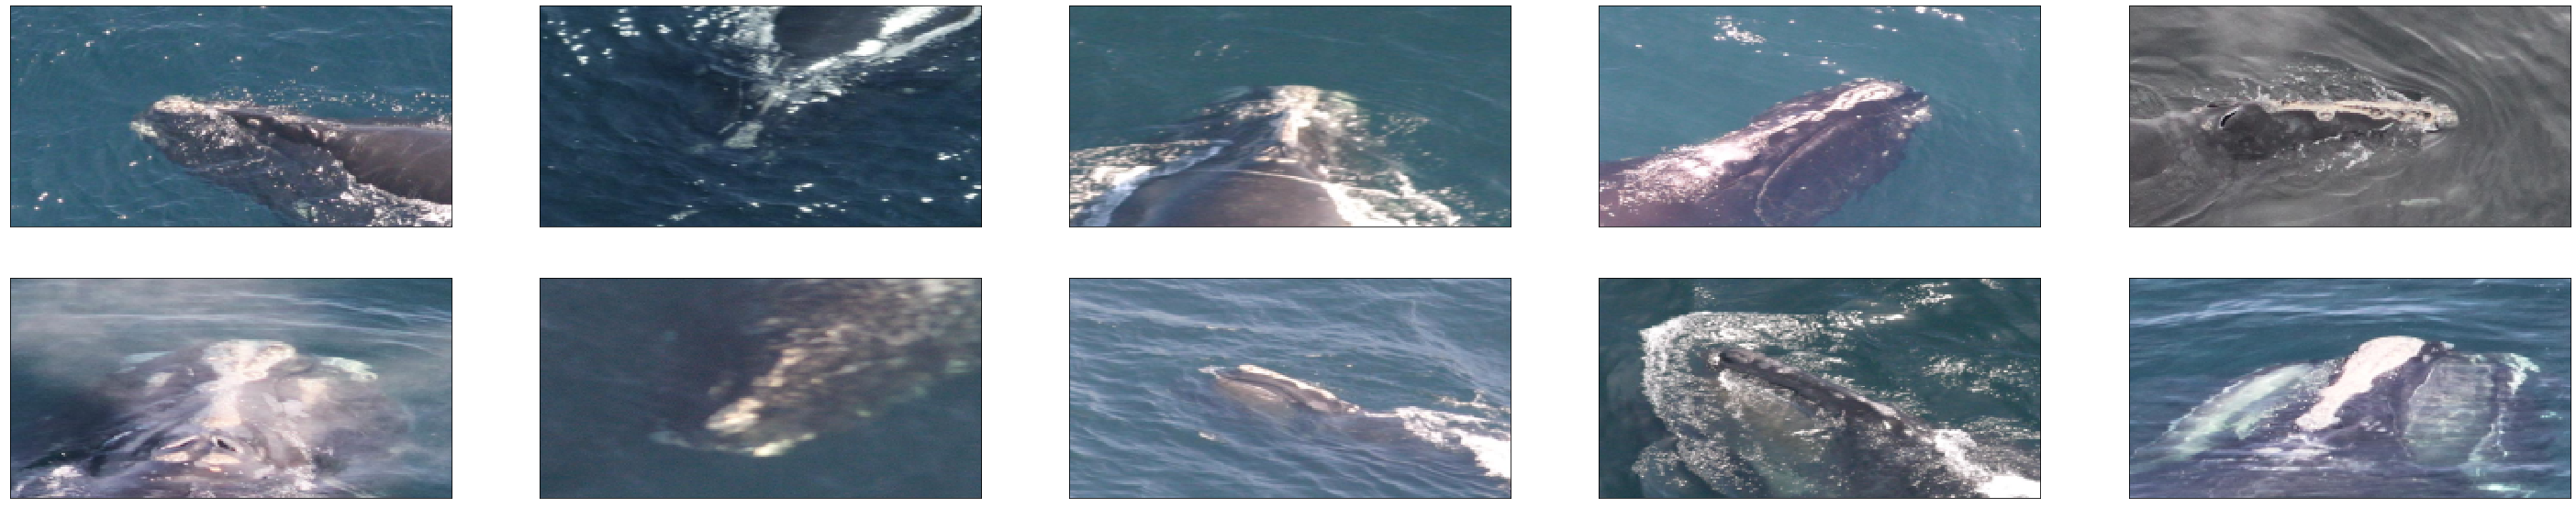

In [37]:
plt.figure(figsize=(50,10))
plt.title('Training images')
for i, image in enumerate(training_cropped[:10]):
    ax = plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
#     plt.grid(False)
    
    # Convert BGR image to RGB:
    img_RGB = image[:, :, ::-1]

    # Show the image using matplotlib:
    plt.imshow(img_RGB.astype(int))

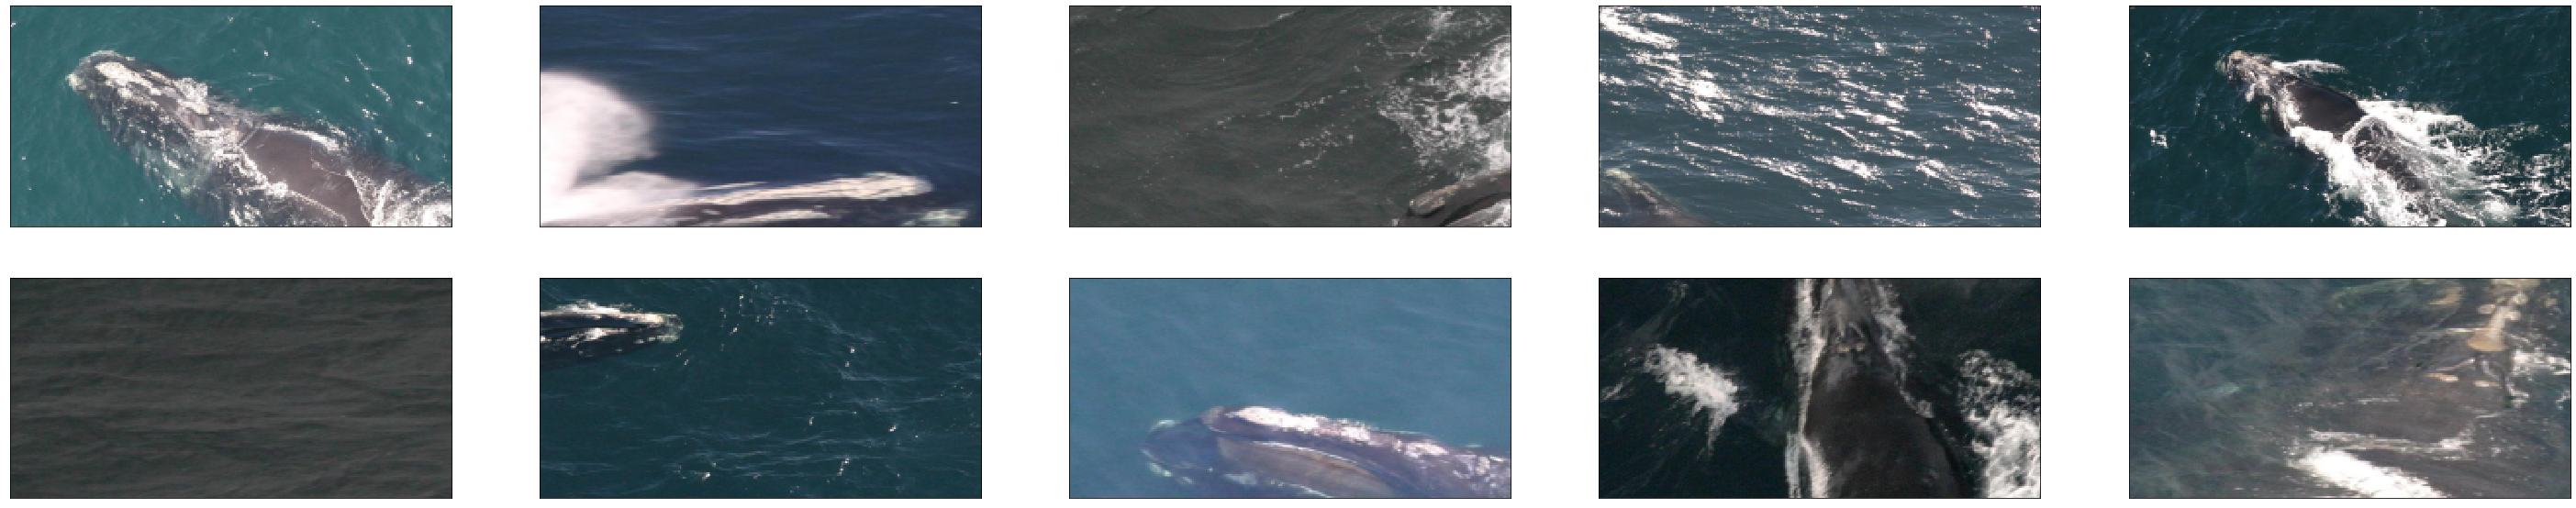

In [26]:
plt.figure(figsize=(50,10))
plt.title('Training images')
for i, image in enumerate(prediction_cropped[:10]):
    ax = plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
#     plt.grid(False)
    
    # Convert BGR image to RGB:
    img_RGB = image[:, :, ::-1]

    # Show the image using matplotlib:
    plt.imshow(img_RGB.astype(int))

As seen, some of the training image suffer from head-less crops which is not a good sign for the classification model. Due to this, even though training goes well, prediction may never be accurate. Hence, manual annotation of bonnetheads and blowholes for all prediction images is a well worth technique. The scientists scanning new whales could point the blowholes and bonnetheads in such a system before recognition.

Below, the whale ID labels are extracted from the data_label dataframe for target values of the training crops. Then a train-test split is carried out for the training crops so that the data can be fed into a classification model.

In [13]:
y = pd.get_dummies(data_label['whaleID'])
columns = y.columns

x_train, x_test, y_train, y_test = train_test_split(training_cropped, y, test_size=0.3)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3180, 128, 256, 3) (1364, 128, 256, 3)
(3180, 447) (1364, 447)


Below code creates a data generator instance from keras for image data and creates augmented data based on parameters as specified.

In [40]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=10,
                        height_shift_range=0.1, zoom_range=0.2)
datagen.fit(x_train)
datagen2 = tf.keras.preprocessing.image.ImageDataGenerator()
datagen2.fit(x_test)

Finally, a CNN model is created below for classification.

In [36]:
np.random.seed(12)
tf.random.set_seed(12)

model2 = keras.Sequential([
    keras.layers.InputLayer(x_train.shape[1:]),
    keras.layers.Conv2D(filters=24, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=48, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=96, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=192, kernel_size=(3, 3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(447, activation=tf.nn.softmax),
])

In [37]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 256, 24)      672       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 42, 85, 24)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 42, 85, 48)        10416     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 28, 48)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 28, 96)        41568     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 9, 96)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 9, 192)        

In [38]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
model2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=8)

Epoch 1/8
25/25 [==============================] - 23s 919ms/step - loss: 4.7443 - accuracy: 0.0950 - val_loss: 7.0125 - val_accuracy: 0.0161
Epoch 2/8
25/25 [==============================] - 23s 920ms/step - loss: 4.3707 - accuracy: 0.1399 - val_loss: 7.2659 - val_accuracy: 0.0176
Epoch 3/8
25/25 [==============================] - 23s 939ms/step - loss: 3.9663 - accuracy: 0.2013 - val_loss: 7.5983 - val_accuracy: 0.0293
Epoch 4/8
25/25 [==============================] - 24s 953ms/step - loss: 3.4349 - accuracy: 0.2846 - val_loss: 8.0096 - val_accuracy: 0.0279
Epoch 5/8
25/25 [==============================] - 23s 934ms/step - loss: 2.8419 - accuracy: 0.3912 - val_loss: 9.0353 - val_accuracy: 0.0330
Epoch 6/8
25/25 [==============================] - 23s 939ms/step - loss: 2.2531 - accuracy: 0.5009 - val_loss: 10.2690 - val_accuracy: 0.0374
Epoch 7/8
25/25 [==============================] - 23s 934ms/step - loss: 1.6979 - accuracy: 0.6145 - val_loss: 11.9341 - val_accuracy: 0.0381
Epoc

CNN with squeeze and excitation block defined below.

In [1]:
# classification model
def squeeze_excite_block2D(filters,input):  
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//32, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se

In [33]:
def make_model():
        s = tf.keras.Input(shape=x_train.shape[1:]) 
        x = tf.keras.layers.Conv2D(24,(3,3),activation='relu',padding='same')(s)
        x = tf.keras.layers.Conv2D(24,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(24,(3,3),activation='relu',padding='same')(x)
        x = squeeze_excite_block2D(24, x)
        x = tf.keras.layers.AveragePooling2D(2)(x)


        x = tf.keras.layers.concatenate([tf.keras.layers.GlobalMaxPooling2D()(x),
                                         tf.keras.layers.GlobalAveragePooling2D()(x)])

        x = tf.keras.layers.Dense(447,activation='softmax',use_bias=False,
                                  kernel_regularizer=tf.keras.regularizers.l1(0.00025))(x) # this make stacking better
        return tf.keras.Model(inputs=s, outputs=x)

In [34]:
np.random.seed(4)
model=make_model()                
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 256, 24) 672         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 256, 24) 5208        conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 256, 24) 5208        conv2d_25[0][0]                  
____________________________________________________________________________________________

In [36]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size=128, epochs=20, verbose=1)

Epoch 1/8
25/25 [==============================] - 122s 5s/step - loss: 7.2078 - accuracy: 0.0016 - val_loss: 6.3401 - val_accuracy: 0.0037
Epoch 2/8
25/25 [==============================] - 126s 5s/step - loss: 6.2977 - accuracy: 0.0038 - val_loss: 6.2694 - val_accuracy: 0.0037
Epoch 3/8
25/25 [==============================] - 129s 5s/step - loss: 6.2212 - accuracy: 0.0060 - val_loss: 6.2344 - val_accuracy: 0.0081
Epoch 4/8
25/25 [==============================] - 131s 5s/step - loss: 6.1401 - accuracy: 0.0082 - val_loss: 6.1819 - val_accuracy: 0.0088
Epoch 5/8
25/25 [==============================] - 129s 5s/step - loss: 6.0788 - accuracy: 0.0107 - val_loss: 6.1743 - val_accuracy: 0.0088
Epoch 6/8
25/25 [==============================] - 123s 5s/step - loss: 6.0433 - accuracy: 0.0091 - val_loss: 6.1677 - val_accuracy: 0.0073
Epoch 7/8
25/25 [==============================] - 119s 5s/step - loss: 6.0131 - accuracy: 0.0138 - val_loss: 6.1553 - val_accuracy: 0.0095
Epoch 8/8
25/25 [===

From the training stats, it is clear that the model did not converge as the validation accuracy is well below training accuracy. This is a classic case of overfitted model where the model has learned to classify the samples in training set but fails to generalise for the validation set.

In [1243]:
predictions = model2.predict(prediction_cropped)

In [1100]:
predictions[:10]

array([[1.97900754e-08, 6.58637691e-06, 6.72307797e-05, ...,
        2.12873441e-10, 3.39762960e-06, 1.21025314e-08],
       [9.79504033e-10, 9.42438305e-08, 1.60790166e-11, ...,
        1.66611080e-08, 6.04914208e-09, 8.10253882e-13],
       [5.65775737e-09, 4.21122621e-07, 1.01163721e-11, ...,
        2.94011329e-06, 2.81401390e-05, 1.19435484e-12],
       ...,
       [3.46339949e-12, 9.20552246e-11, 1.90689261e-13, ...,
        8.65770942e-14, 2.78583423e-09, 2.82978393e-14],
       [2.10627732e-07, 9.61788604e-09, 1.73961624e-07, ...,
        8.76269496e-06, 1.25305072e-04, 2.16690832e-11],
       [2.85028750e-06, 4.12788775e-10, 1.10984494e-07, ...,
        1.23826676e-05, 2.06283812e-09, 8.54413827e-07]], dtype=float32)

Below the predictions are formatteed into array that is similar to sample_submission.csv

In [1244]:
results = np.zeros(447).reshape(1,447)
for pred in predictions:
    index = np.argmax(pred)
    arr = np.zeros(447)
    arr[index] = 1.0
    arr = arr.reshape(1,447)
    results = np.append(results, arr, axis = 0)

In [1245]:
results = np.delete(results, 0, axis=0)
results[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [1106]:
results.shape

(6925, 447)

Below, the array is changed to a pands dataframe for easy export to csv with columns names for each whales.

In [1246]:
results_df = pd.DataFrame(results, columns = columns)

In [1247]:
results_df.tail()

,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,whale_03935,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
6920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Adding the filenames columns for prediction images as sample submission contains it.

In [1132]:
fil = pd.DataFrame(prediction_files, columns=['Image'])

In [1229]:
fil.tail()

,Image
6920,w_9995.jpg
6921,w_9996.jpg
6922,w_9997.jpg
6923,w_9998.jpg
6924,w_9999.jpg


Creating the final dataframe that will be exported.

In [1248]:
d2f = pd.concat((fil, results_df), axis=1, join='inner')

In [1212]:
d2f.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
0,w_0.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,w_10.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,w_10000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,w_10001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,w_10002.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally we also read the sample submission csv and arrange the predicitons in the same order as in the sample_submission.csv

In [1143]:
sub = pd.read_csv('sample_submission.csv')

In [1147]:
sub = sub['Image'].tolist()

In [1231]:
sub[:10]

['w_1947.jpg',
 'w_11096.jpg',
 'w_10973.jpg',
 'w_10442.jpg',
 'w_10606.jpg',
 'w_11167.jpg',
 'w_1464.jpg',
 'w_5072.jpg',
 'w_5492.jpg',
 'w_10124.jpg']

In [1232]:
d2f.tail()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
6920,w_9995.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6921,w_9996.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6922,w_9997.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,w_9998.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6924,w_9999.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1199]:
sorterIndex = dict(zip(sub,range(len(sub))))

In [1249]:
d2f['temp_rank'] = d2f['Image'].map(sorterIndex)

In [1234]:
d2f.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573,Tm_Rank
0,w_0.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2105
1,w_10.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2845
2,w_10000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1075
3,w_10001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6782
4,w_10002.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2176


In [1250]:
d2f.sort_values(['temp_rank'], ascending = True, inplace = True, ignore_index=True)
d2f.drop('temp_rank', 1, inplace = True)

In [1251]:
d2f.tail()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
6920,w_4867.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6921,w_5230.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6922,w_5278.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,w_9218.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6924,w_9316.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, the dataframe d2f is exported as a csv for kaggle submission.

In [1252]:
d2f.to_csv('submission.csv', index=False)